In [1]:
import re
import typing as t
from collections import defaultdict
from pathlib import Path

import matplotlib.pyplot as plt
import nltk
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from nltk.corpus import wordnet, stopwords
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

In [2]:
# @formatter:off
%matplotlib inline
# @formatter:on

In [3]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\super\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\super\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\super\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\super\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\super\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [4]:
torch.set_warn_always(True)

sns.set_theme()
plt.rcParams["figure.figsize"] = (8, 4)

In [5]:
DATA_DIR = Path("../data/")

CUDA = "cuda"
CPU = "cpu"
DEVICE = CUDA if torch.cuda.is_available() else CPU
print(f"Using {DEVICE.upper()} device")

Using CUDA device


## Предобработка данных и подготовка датасета

In [6]:
def get_pos(word: str) -> str:
    tag = nltk.pos_tag([word])[0][1]
    if tag.startswith("J"):
        return wordnet.ADJ
    elif tag.startswith("V"):
        return wordnet.VERB
    elif tag.startswith("R"):
        return wordnet.ADV
    else:
        return wordnet.NOUN


_wordnet_lemmatizer = nltk.WordNetLemmatizer()


def wordnet_lemmatizer(token: str) -> str:
    return _wordnet_lemmatizer.lemmatize(token, pos=get_pos(token))


RE_URL = re.compile(r"\w+://\S+", flags=re.MULTILINE)
RE_NOT_ASCII_LOW = re.compile(r"[^a-z]", flags=re.MULTILINE)
STOPWORDS = set(stopwords.words("english"))


def preprocess_text(
        text: str,
        lemmatizer_or_stemmer: t.Callable[[str], str] = None,
        min_word_len: int = 0,
) -> str:
    text = text.lower()
    for pat in [RE_URL, RE_NOT_ASCII_LOW]:
        text = pat.sub(" ", text)

    words = []
    for word in nltk.word_tokenize(text):
        if word not in STOPWORDS and len(word) >= min_word_len:
            if not lemmatizer_or_stemmer:
                words.append(word)
                continue
            word = lemmatizer_or_stemmer(word)
            if word not in STOPWORDS and len(word) >= min_word_len:
                words.append(word)

    return " ".join(words)


class WordVocab:
    pad = "<PAD>"
    unknown = "<UNK>"

    def __init__(self, texts: t.List[str]):
        uniques = set()
        max_len = 0
        for text in texts:
            words = nltk.word_tokenize(text)
            uniques.update(words)
            max_len = max(len(words), max_len)

        self.alphabet = [self.pad, self.unknown, *uniques]
        self.max_len = max_len

        w2i = {w: i for i, w in enumerate(self.alphabet)}
        unknown_idx = w2i[self.unknown]
        self.w2i = defaultdict(lambda: unknown_idx, w2i)

    def __len__(self):
        return len(self.alphabet)

    def encode(self, text: str) -> torch.Tensor:
        indices = [self.w2i[w] for w in nltk.word_tokenize(text)]
        indices += [self.w2i[self.pad]] * (self.max_len - len(indices))
        return torch.tensor(indices, dtype=torch.long)

    def decode(self, indices: torch.Tensor) -> str:
        pad_indices = torch.nonzero(indices == self.w2i[self.pad], as_tuple=True)[0]  # noqa
        if len(pad_indices):
            indices = indices[:pad_indices[0]]
        return " ".join(self.alphabet[i] for i in indices)

In [21]:
class NewsDataset(Dataset):
    DATA_COL = "Description"  # или Title
    TARGET_COL = "Class Index"

    raw_texts: t.List[str]
    texts: t.List[str]

    encoder: LabelEncoder
    classes: t.List[str]

    vocab: WordVocab
    data: torch.Tensor
    targets: torch.Tensor

    def __init__(self, df: pd.DataFrame, vocab: WordVocab = None, encoder: LabelEncoder = None):
        self.raw_texts = df[self.DATA_COL].tolist()
        with tqdm(total=len(df)) as pbar:
            self._pbar, self._i, self._n = pbar, 0, 100
            self.texts = [self.preprocess_text(text) for text in self.raw_texts]
        self.vocab = vocab or WordVocab(self.texts)

        if encoder:
            self.encoder = encoder
            encode = self.encoder.transform
        else:
            self.encoder = LabelEncoder()
            encode = self.encoder.fit_transform

        self.data = torch.vstack([self.vocab.encode(text) for text in self.texts])
        targets = encode(df[self.TARGET_COL])
        self.classes = [str(cls) for cls in self.encoder.classes_]
        self.targets = torch.tensor(targets, dtype=torch.long)

    def __len__(self):
        return self.data.size(0)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

    def preprocess_text(self, text: str) -> str:
        self._i += 1
        if self._i % self._n == 0:
            self._pbar.update(self._n)
        return preprocess_text(text, lemmatizer_or_stemmer=wordnet_lemmatizer, min_word_len=3)

1    2575
4    2489
3    2475
2    2461
Name: Class Index, dtype: int64


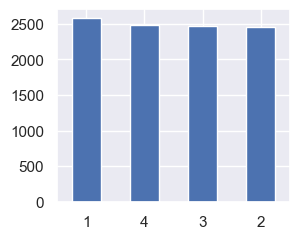

In [22]:
news_df = pd.read_csv(DATA_DIR / "nlp/news.csv")
vc = news_df["Class Index"].value_counts()
print(vc)
news_df["Class Index"].value_counts().plot.bar(rot=0, figsize=(3, 2.5));

In [23]:
train_df, test_df = train_test_split(news_df, test_size=0.2, random_state=0)

train_dataset = NewsDataset(train_df)
test_dataset = NewsDataset(
    test_df,
    vocab=train_dataset.vocab,
    encoder=train_dataset.encoder,
)
print(len(train_dataset.vocab), train_dataset.vocab.max_len)
len(train_dataset), len(test_dataset), train_dataset.classes

100%|██████████| 2000/2000 [00:18<00:00, 110.40it/s]


15247 68


(8000, 2000, ['1', '2', '3', '4'])

## Построение и обучение модели

In [24]:
def get_weights(targets: torch.Tensor) -> torch.Tensor:
    _, counts = targets.unique(return_counts=True)
    return counts.max() / counts


def common_train(
        model: nn.Module,
        loss_fn: nn.Module,
        optimizer: optim.Optimizer,
        epochs: int,
        train_dataloader: DataLoader,
        test_dataloader: DataLoader,
        verbose: int = None,
        device: str = CPU,
) -> t.Tuple[t.List[float], t.List[float], t.List[float], t.List[float]]:
    train_losses, train_accuracy_list = [], []
    test_losses, test_accuracy_list = [], []
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}\n" + "-" * 32)

        train_loss, train_accuracy = train_loop(train_dataloader, model, loss_fn, optimizer, verbose, device)
        print(f"Train Error: loss: {train_loss:.6f}, accuracy: {train_accuracy:.4f}")
        train_losses.append(train_loss)
        train_accuracy_list.append(train_accuracy)

        test_loss, test_accuracy = test_loop(test_dataloader, model, loss_fn, device)
        print(f" Test Error: loss: {test_loss:.6f}, accuracy: {test_accuracy:.4f}\n")
        test_losses.append(test_loss)
        test_accuracy_list.append(test_accuracy)

        torch.cuda.empty_cache()
    return train_losses, train_accuracy_list, test_losses, test_accuracy_list


def train_loop(
        dataloader: DataLoader,
        model: nn.Module,
        loss_fn: nn.Module,
        optimizer: optim.Optimizer,
        verbose: int = None,
        device: str = CPU,
) -> t.Tuple[float, float]:
    model.train()

    size = len(dataloader.dataset)  # noqa
    num_batches = len(dataloader)
    avg_loss, avg_accuracy = 0, 0

    for batch, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)

        pred = model(x)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        y_true = torch.flatten(y).detach().cpu()
        y_pred = torch.flatten(pred.argmax(1)).detach().cpu()
        accuracy = metrics.accuracy_score(y_true, y_pred)

        avg_loss += loss
        avg_accuracy += accuracy
        if verbose and batch % verbose == 0:
            print(f"[{batch * len(x):>4d}/{size:>4d}]: loss: {loss:.6f}, accuracy: {accuracy:.4f}")

        del x, y, pred, loss
        torch.cuda.empty_cache()

    return (avg_loss / num_batches).item(), avg_accuracy / num_batches


@torch.no_grad()
def test_loop(
        dataloader: DataLoader,
        model: nn.Module,
        loss_fn: nn.Module,
        device: str = CPU,
) -> t.Tuple[float, float]:
    model.eval()
    y_true, y_pred = get_y_true_y_pred(model, dataloader, device)
    return loss_fn(y_pred, y_true).item(), metrics.accuracy_score(y_true.cpu(), y_pred.argmax(1).cpu())


@torch.no_grad()
def get_y_true_y_pred(
        model: nn.Module,
        dataloader: DataLoader,
        device: str = CPU,
) -> t.Tuple[torch.Tensor, torch.Tensor]:
    model.eval()

    y_test = []
    y_pred = []
    for x, y in dataloader:
        x, y = x.to(device), y.to(device)
        pred = model(x)
        y_test.append(y)
        y_pred.append(pred)

        del x
        torch.cuda.empty_cache()

    return torch.flatten(torch.vstack(y_test)), torch.vstack(y_pred)


def plot_train_test(
        train_losses: t.List[float],
        train_accuracy: t.List[float],
        test_losses: t.List[float],
        test_accuracy: t.List[float],
) -> None:
    fig, axes = plt.subplots(2, 1, figsize=(6, 7))
    epochs = torch.arange(len(train_losses))

    axes[0].plot(epochs, train_losses)
    axes[0].plot(epochs, test_losses)
    axes[0].set_ylabel("loss")
    axes[0].legend(["train", "test"])

    axes[1].plot(epochs, train_accuracy)
    axes[1].plot(epochs, test_accuracy)
    axes[1].set_xlabel("epoch")
    axes[1].set_ylabel("accuracy")

In [128]:
class NewsCNNClassifier(nn.Module):
    LAST_CONV_OUT_CHANNELS = 128
    ADAPTIVE_AVG_POOL = 16

    def __init__(
            self,
            num_embeddings: int,
            embedding_dim: int,
            num_classes: int,
    ):
        super().__init__()
        self.embedding = nn.Embedding(num_embeddings=num_embeddings, embedding_dim=embedding_dim, padding_idx=0)
        self.features = nn.Sequential(
            nn.Conv1d(in_channels=embedding_dim, out_channels=64, kernel_size=2),
            nn.BatchNorm1d(num_features=64),
            nn.ReLU(),
            nn.Dropout(),
            nn.MaxPool1d(kernel_size=2),
            nn.Conv1d(in_channels=64, out_channels=self.LAST_CONV_OUT_CHANNELS, kernel_size=2),
            nn.BatchNorm1d(num_features=self.LAST_CONV_OUT_CHANNELS),
            nn.ReLU(),
            nn.Dropout(),
            nn.MaxPool1d(kernel_size=2),
        )
        self.avgpool = nn.AdaptiveAvgPool1d(self.ADAPTIVE_AVG_POOL)
        self.classifier = nn.Sequential(
            nn.Linear(self.LAST_CONV_OUT_CHANNELS * self.ADAPTIVE_AVG_POOL, 256),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(256, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.embedding(x)
        x = torch.permute(x, dims=(0, 2, 1))

        x = self.features(x)
        x = self.avgpool(x)

        x = torch.flatten(x, 1)
        return self.classifier(x)

In [129]:
torch.manual_seed(0)

net = NewsCNNClassifier(
    num_embeddings=len(train_dataset.vocab),
    embedding_dim=256,
    num_classes=len(train_dataset.classes),
).to(DEVICE)
loss_fn = nn.CrossEntropyLoss(weight=get_weights(train_dataset.targets).to(DEVICE))
optimizer = optim.Adam(net.parameters(), lr=0.001)

train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=512, drop_last=True)

net

NewsCNNClassifier(
  (embedding): Embedding(15247, 256, padding_idx=0)
  (features): Sequential(
    (0): Conv1d(256, 64, kernel_size=(2,), stride=(1,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv1d(64, 128, kernel_size=(2,), stride=(1,))
    (6): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): Dropout(p=0.5, inplace=False)
    (9): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool1d(output_size=16)
  (classifier): Sequential(
    (0): Linear(in_features=2048, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=256, out_features=4, bias=True)
  )
)

In [130]:
%%time

train_losses, train_accuracy, test_losses, test_accuracy = common_train(
    epochs=10,
    model=net,
    loss_fn=loss_fn,
    optimizer=optimizer,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    device=DEVICE,
)

Epoch 1
--------------------------------
Train Error: loss: 1.392839, accuracy: 0.2918
 Test Error: loss: 1.320116, accuracy: 0.4245

Epoch 2
--------------------------------
Train Error: loss: 1.099236, accuracy: 0.5073
 Test Error: loss: 0.803865, accuracy: 0.7467

Epoch 3
--------------------------------
Train Error: loss: 0.729344, accuracy: 0.7180
 Test Error: loss: 0.616716, accuracy: 0.8118

Epoch 4
--------------------------------
Train Error: loss: 0.549828, accuracy: 0.8003
 Test Error: loss: 0.531974, accuracy: 0.8346

Epoch 5
--------------------------------
Train Error: loss: 0.433536, accuracy: 0.8501
 Test Error: loss: 0.473963, accuracy: 0.8392

Epoch 6
--------------------------------
Train Error: loss: 0.377364, accuracy: 0.8677
 Test Error: loss: 0.456356, accuracy: 0.8516

Epoch 7
--------------------------------
Train Error: loss: 0.318244, accuracy: 0.8905
 Test Error: loss: 0.443493, accuracy: 0.8483

Epoch 8
--------------------------------
Train Error: loss: 0.

## Оценка и выводы

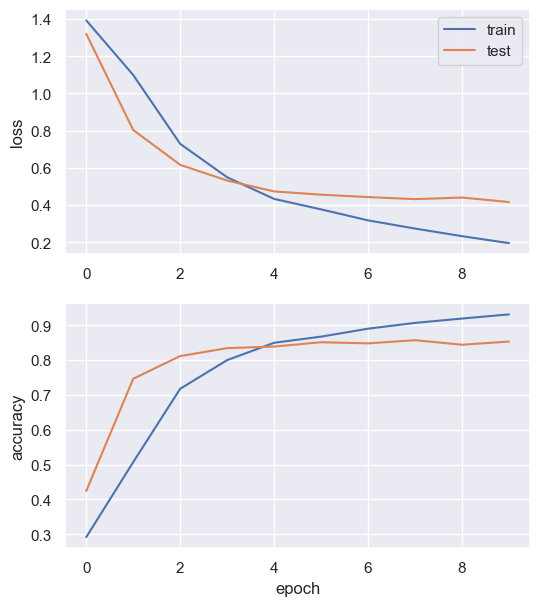

In [131]:
plot_train_test(train_losses, train_accuracy, test_losses, test_accuracy)

In [132]:
y_true, y_pred = get_y_true_y_pred(net, test_dataloader, DEVICE)
y_true, y_pred = y_true.cpu(), y_pred.argmax(1).cpu()

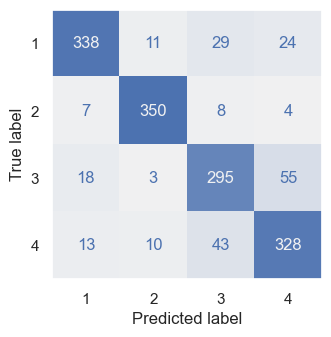

In [133]:
cm_display = metrics.ConfusionMatrixDisplay.from_predictions(
    y_true,
    y_pred,
    display_labels=test_dataset.classes,
    colorbar=False,
    xticks_rotation=0,
    cmap=sns.color_palette('light:b', as_cmap=True)
)
cm_display.ax_.grid(False)
cm_display.figure_.set_size_inches(3.5, 3.5)

In [134]:
print(metrics.classification_report(y_true, y_pred, target_names=test_dataset.classes, zero_division=True))

              precision    recall  f1-score   support

           1       0.90      0.84      0.87       402
           2       0.94      0.95      0.94       369
           3       0.79      0.80      0.79       371
           4       0.80      0.83      0.81       394

    accuracy                           0.85      1536
   macro avg       0.85      0.85      0.85      1536
weighted avg       0.85      0.85      0.85      1536



In [135]:
net.eval()
for i in torch.randperm(len(test_dataset))[:5]:
    x, y = test_dataset[i]
    x, y = x.to(DEVICE), y.to(DEVICE)
    pred = net(x.unsqueeze(0))

    pred_proba, pred_label_indices = torch.softmax(pred, 1).topk(min(len(test_dataset.classes), 3), dim=1)
    pred_labels = test_dataset.encoder.inverse_transform(pred_label_indices.squeeze().cpu())
    predicts = ", ".join([f"{label} ({prob:.2f})" for (label, prob) in zip(pred_labels, pred_proba.squeeze())])

    text = test_dataset.texts[i]
    text = text if len(text) < 80 else text[:80] + "..."
    target = test_dataset.encoder.inverse_transform([y.cpu()])[0]

    print(f"Input:   {text}")
    print(f"Target:  {target}")
    print(f"Predict: {predicts}\n")

Input:   canadian press toronto ontario high court order new trial robert baltovich convi...
Target:  1
Predict: 1 (0.86), 4 (0.10), 2 (0.03)

Input:   washington redskin ranked valuable team nfl surpass billion first american sport...
Target:  2
Predict: 2 (0.96), 1 (0.03), 4 (0.00)

Input:   gaza reuters israeli force thursday blew two palestinian housing bloc gaza refug...
Target:  1
Predict: 1 (1.00), 4 (0.00), 2 (0.00)

Input:   athens greece response two score controversy overshadow best gymnastics performa...
Target:  2
Predict: 2 (0.61), 1 (0.23), 4 (0.12)

Input:   stock market look start fourth week gain another drop oil price give aid stock m...
Target:  3
Predict: 3 (0.97), 1 (0.03), 4 (0.00)

